# Med Student Qualtrics Results - Clinical Questionaire
------
The clinical questionaire is comprised of 3 tasks (Diabetes, Hypertension, Depression) and 21 questions. There are several ways to begin analyzing the data set:

- **Read-in the data**
- Score (Number of correctly answered questions)
    - [Overall](#oscore)
- [Time-to-Complete](#ttc)
- [Individual-Question Comparisons](#iqc)


## Read-in the data
-----
Before we begin looking at data, we need to read it in. In this next step, we will read in the data from the clinical questionaire (both control and intervention surveys) as well as some metadata about the survey itself. Notice the two outliers, we'll remove these two observations.

In [7]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

cq_control = pd.read_csv(header=1,filepath_or_buffer=open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire__Control.csv","rb"))
cq_interve = pd.read_csv(header=1,filepath_or_buffer=open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire__Intervention.csv","rb"))
dd = json.load(open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire_-_Control.qsf.txt","r"))
#we'll need labels for things so let's go ahead and create them
cq_interve['label'] = "intervention"
cq_control['label'] = "control"
#We'll need a function to help extract needed metadata
final = pd.concat([cq_interve,cq_control])

final_df = final[['Score-sum','label','Q_TotalDuration']]
final_df_nm = final_df.dropna()
final_df_nm['Score'] = final_df_nm['Score-sum']
final_df_nm.head()

,Score-sum,label,Q_TotalDuration,Score
0,21,intervention,1153,21
1,22,intervention,556,22
2,22,intervention,869,22
3,23,intervention,985,23
4,21,intervention,799,21


## Score
------
Each question is worth 1 point, except for 3 multiple choice questions. For these 3 questions, there are 2 correct answers. This leads to a variable whose min is 0 and max is 24. We will regress several variables on this response to explore our hypotheses. First let's take another look at the distribution.

<a id='oscore'></a>
### Overall
---------
*The overall score has a possible maximum of **24**.*

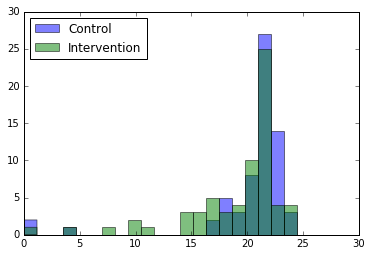

In [2]:
#Make a histogram
import random
import numpy
from matplotlib import pyplot

x = cq_control['Score-sum']
y = cq_interve['Score-sum']

bins = numpy.linspace(0, 28, 25)

pyplot.hist(x, bins, alpha=0.5, label='Control')
pyplot.hist(y, bins, alpha=0.5, label='Intervention')
pyplot.legend(loc='upper left')
pyplot.show()

>Previously, we tested the [unadjusted association](./med_student_qualtrics_cq.ipynb) between treatment and overall score using the Mann-Whitney test. The next leg of our analysis concentrates on testing another hypotheses. Specifically, that there is an interaction between time and the treatment effect. In order to explore this hypothesis, we will now move to a modeling (regression) framework. Specifically, we'll build the following model:

$$Y_{overallScore}=\beta_{0}+x_{treatment}\beta_{1}+x_{time-to-complete}\beta_{2}+x_{treatment}x_{time-to-complete}\beta_{3}$$

>This model allows us to test the null hypothesis $H_{0}:\beta_{3}=0$. This interaction effect let's us test the hypothesis that there is an interaction between time-to-complete and treatment. If significant ($\alpha 0.05$) level, then we will display the time-to-complete effect within each treatment arms. By treating time as continuous we will have more power to detect a signal (rather than categorizing time).

<a id='dscore'></a>
## Linear Models
---------
### Unadjusted (Within Modeling Framework)
Before we get started, it might be helpful to walk before running, so let's build a simpler model that represents our unadjusted hypothesis and see how that compares with the T-Test test run earlier. To sum it up, here is the first model we will build before getting to the hypothesis of interest:

$$Y_{overallScore}=\beta_{0}+x_{treatement}\beta_{1}$$

In [4]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices('Score ~ label',data=final_df_nm, return_type='dataframe')

# Fit and summarize OLS model
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.837
Date:                Mon, 15 Aug 2016   Prob (F-statistic):             0.0945
Time:                        13:56:44   Log-Likelihood:                -386.74
No. Observations:                 132   AIC:                             777.5
Df Residuals:                     130   BIC:                             783.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                20.35

#### Results
------------
>In this exercise, we get the same results as previously seen on the [unadjusted association](./med_student_qualtrics_cq.ipynb). The only difference, is that we've now framed our t-test within a modeling framework. Notice that we get the same inference by looking at the effect label[T.intervention] and the pvalue (i.e. P>|t| = 0.094 for this effect). This says that we don't have enough evidence to reject the null hypothesis of the effect being different from 0. Of course, in this iteration we really want to 'control' for time-to-complete. So we'll look into that in the next analysis.

### Adjusted (for time-to-complete)
Now, we'll build the following model:
$$Y_{overallScore}=\beta_{0}+x_{treatment}\beta_{1}+x_{time-to-complete}\beta_{2}$$

In [5]:
y, X = dmatrices('Score ~ label + Q_TotalDuration',data=final_df_nm, return_type='dataframe')

# Fit and summarize OLS model
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.586
Date:                Mon, 15 Aug 2016   Prob (F-statistic):              0.209
Time:                        13:56:50   Log-Likelihood:                -386.56
No. Observations:                 132   AIC:                             779.1
Df Residuals:                     129   BIC:                             787.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                20.24

#### Results
----------
Now that we've adjusted for time-to-complete, notice the line `label[T.intervention]`. The pvalue barely changed (0.092). This means that when we look at individuals with similar time-to-complete numbers (say 10 mins) when we compare the treatment and control, the scores still are **not significantly** different. Now, this could be a power issue (i.e. if we collected more data, we'd see a difference). But the difference that we'd see would point in a direction opposite our hypothesis. This data seems to suggest that the intervention gets **lower overall scores**. Note the effect (-1.3523).

### Interaction: Time-to-complete and Treatment
Finally, does the effect of treatment behave differently for individuals who finish at different times? We'll build the model originally described:
$$Y_{overallScore}=\beta_{0}+x_{treatment}\beta_{1}+x_{time-to-complete}\beta_{2}+x_{treatment}x_{time-to-complete}\beta_{3}$$


In [6]:
y, X = dmatrices('Score ~ label + Q_TotalDuration + label*Q_TotalDuration',data=final_df_nm, return_type='dataframe')

# Fit and summarize OLS model
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.158
Date:                Mon, 15 Aug 2016   Prob (F-statistic):              0.328
Time:                        13:56:54   Log-Likelihood:                -386.40
No. Observations:                 132   AIC:                             780.8
Df Residuals:                     128   BIC:                             792.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

#### Results
--------
>To get the results for this hypothesis, we need to look at the line `label[T.intervention]:Q_TotalDuration` - this is the interaction effect and tests if there is a 'differential treatment effect' for different levels of time-to-complete. Because the pvalue is > 0.05 (i.e. 0.566), we do not find evidence to suggest a 'differential treatment effect'.

## Nonlinear Models?
-----
In our previous models, we assumed a linear relationship. Does this make sense? Let's visually explore these relationships.


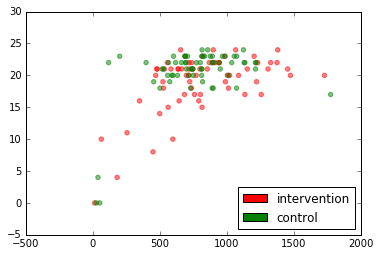

In [13]:
final_df_nm_no = final_df_nm[final_df_nm['Q_TotalDuration'] < 10000]
colors = ['red' if x=='intervention' else 'green' for x in final_df_nm_no['label']]
plt.scatter(final_df_nm_no['Q_TotalDuration'],final_df_nm_no['Score'],color=colors, alpha=0.5)
import matplotlib.patches as mpatches
classes = ['intervention','control']
class_colours = ['r','g']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4)

[Return to Main Notebook](main_med_student.ipynb)